# Recurrent Neural Networks - Assignment Part 1
#### Authors:
- Izquierdo Álvarez, Mario
- Romero Romero, Martín

### Import necessary packages

In [1]:
import os
import sys

In [2]:
utils_path = os.path.join('.','utils')
os.sys.path.append(utils_path)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from rich import print

from keras.layers import Input, SimpleRNN, Dense, LSTM
from keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd

In [5]:
from utils.generateWalmartDataset2 import generateTrainTestData

ModuleNotFoundError: No module named 'sklearn'

### Utility Functions

- Here we define two main functions used for plotting and saving the results.

In [5]:
def plot(history):
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(mae) + 1)

    # Create subplots and unpack the axes array immediately
    fig, (ax_mae, ax_loss) = plt.subplots(1, 2, figsize=(20, 6))  # figsize=(width, height) in inches

    # Plot training and validation mae on the first axis
    ax_mae.plot(epochs, mae, 'b-o', label='Training MAE')
    ax_mae.plot(epochs, val_mae, 'r-o', label='Validation mae')
    ax_mae.set_title('Training and Validation mae')
    ax_mae.legend()
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')

    # Plot training and validation loss on the second axis
    ax_loss.plot(epochs, loss, 'b-o', label='Training loss')
    ax_loss.plot(epochs, val_loss, 'r-o', label='Validation loss')
    ax_loss.set_title('Training and Validation Loss')
    ax_loss.legend()
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')

    # Display the plot
    plt.show()

In [6]:
def save_model_results(file_path, model_name, accuracy):
    """
    This function saves the model's accuracy to a CSV file. It checks if the file exists
    to add a header if necessary and then opens the file in append mode to add
    the model name and accuracy.
    """
    # Check if the file exists to decide on adding the header
    header_needed = not os.path.isfile(file_path)
    
    # Open the file in append mode, which creates the file if it doesn't exist
    with open(file_path, "a") as file:
        # Add a header if the file was just created
        if header_needed:
            file.write("model_name,accuracy\n")
        # Append the model name and accuracy to the file
        file.write(f"{model_name},{accuracy:.3f}\n")

In [7]:
def csv_to_dict(path):
    # Read the CSV file
    data = pd.read_csv(path)
    
    # Ensure 'model_name' and 'accuracy' columns exist
    if 'model_name' not in data.columns or 'accuracy' not in data.columns:
        raise ValueError("The CSV must contain 'model_name' and 'accuracy' columns")
    
    # Convert to dictionary
    models_dict = pd.Series(data.accuracy.values, index=data.model_name).to_dict()
    
    return models_dict

In [8]:
def plot_results_grouped(results_dicts, title='Accuracy for Custom and Pretrained Models', figsize=(20, 10), font_size=12, y_lim = None):
    ''' 
    This function allows plotting several configurations of different methods on the same bar plot.
    A dictionary with each method as the key and with configurations and results dict as the value will be used as input.
    Example: {'Method_1': {'config_1':(1, 0.5), ...}, 'Method_2':{...}...}. Each Method will be plotted with a different color.
    '''
    
    methods = list(results_dicts.keys())
    colors = ['seagreen', 'tan', 'lightsteelblue', 'mediumpurple', 'dimgrey']  # Colors for each method
    color_map = dict(zip(methods, colors[:len(methods)]))
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35  # Bar width
    
    total_configs = sum([len(results_dicts[method]) for method in methods])  # Total configurations
    x = np.linspace(0, total_configs * width * 1.5, total_configs)  # Spacing
    
    min_value = float('inf')  # Initialize max value for accuracy
    
    current_position = 0
    for method in methods:
        labels = list(results_dicts[method].keys())
        results = list(results_dicts[method].values())
        
        # Update min_value if current results contain a new min
        min_value = min(min_value, min(results))
        
        # Creating the bars for each method
        rects = ax.bar(x[current_position:current_position+len(labels)], results, width,
                       label=method, color=color_map[method], alpha=0.6)
        ax.bar_label(rects, padding=3, fontsize=font_size)
        
        current_position += len(labels)  # Update the position for the next group of bars
    
    ax.set_ylabel('MAE', fontsize=font_size)
    ax.set_title(title, fontsize=font_size + 2)
    
    all_labels = [config for method in methods for config in results_dicts[method]]
    ax.set_xticks(x[:len(all_labels)])
    ax.set_xticklabels(all_labels, rotation=45, ha="right", fontsize=font_size)
    
    ax.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    ax.tick_params(axis='y', labelsize=font_size)
    if y_lim:
        plt.ylim(*y_lim)
    else:
        plt.ylim(0, max_value + 0.1)  # Adjust y_lim to make sure min_value is visible
    
    # Draw a horizontal line at the maximum accuracy value
    plt.axhline(y=min_value, color='brown', alpha=0.6, linestyle='--', label=f'Min MAE: {min_value}')
    plt.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    fig.tight_layout()
    plt.show()

In [9]:
def filter_models_by_keywords(results_dict, keywords):
    """
    Filters the given dictionary of model results based on a list of keywords.
    Each keyword generates a new dictionary containing key-value pairs from the
    results_dict where the key includes the keyword. Each pair is only included
    in the first matching dictionary based on the order of the keywords list.
    
    :param results_dict: Dictionary with model names as keys and numerical results as values.
    :param keywords: List of keywords to filter the models by.
    :return: List of dictionaries, each corresponding to one of the keywords.
    """
    # Initialize a list to store the resulting dictionaries
    filtered_results = {}
    # Initialize a set to keep track of models that have already been added
    added_models = set()
    
    # Iterate over each keyword
    for keyword in keywords:
        # Create a new dictionary for the current keyword
        current_dict = {}
        # Iterate over each item in the original dictionary
        for model_name, result in results_dict.items():
            # Check if the model name contains the current keyword and hasn't been added yet
            if keyword in model_name and model_name not in added_models:
                # Add the model-result pair to the current dictionary
                current_dict[model_name] = result
                # Mark the model as added
                added_models.add(model_name)
        # Add the current dictionary to the list of filtered results
        filtered_results[keyword] = current_dict
    
    return filtered_results

### Define some global variables

In [10]:
val_results_path = "val_results.csv"
test_results_path = "test_results.csv"

In [11]:
testPercent = 0.2
valPercent = 0.1
seqLength = 3
batchSize = 4
nFeatures = 6

### Prepare data time series

In [9]:
trainData, valData, testData, stdSales, nFeatures = generateTrainTestData("./data/walmart-sales-dataset-of-45stores.csv",
    valPercent, testPercent, seqLength, batchSize) 

## **SimpleRNN**
Let's use a single SimpleRNN layer for our first model.
### Bulding model

In [10]:
model_name = "SimpleRNN_5"

In [11]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=5, activation='relu')(inputs)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer (InputLayer)           │ (None, 3, 6)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn (SimpleRNN)             │ (None, 5)                     │          60 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 1)                     │           6 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
history = model.fit(trainData, epochs=10, batch_size=batchSize, validation_data=valData)

Epoch 1/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9694 - mae: 0.9694 - val_loss: 0.4330 - val_mae: 0.4330
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3496 - mae: 0.3496 - val_loss: 0.4414 - val_mae: 0.4414
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2880 - mae: 0.2880 - val_loss: 0.3830 - val_mae: 0.3830
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2721 - mae: 0.2721 - val_loss: 0.2970 - val_mae: 0.2970
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2433 - mae: 0.2433 - val_loss: 0.2337 - val_mae: 0.2337
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2253 - mae: 0.2253 - val_loss: 0.1972 - val_mae: 0.1972
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2114 - mae: 0.2114 - val_loss: 0.2053 - val_mae: 0.2053
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2047 - mae: 0.2047 - val_loss: 0.2172 - val_mae: 0.2172
Epoch 9/10
1080/1080 ━━━━━━━━━━━━━━━━━━━

### Evaluation

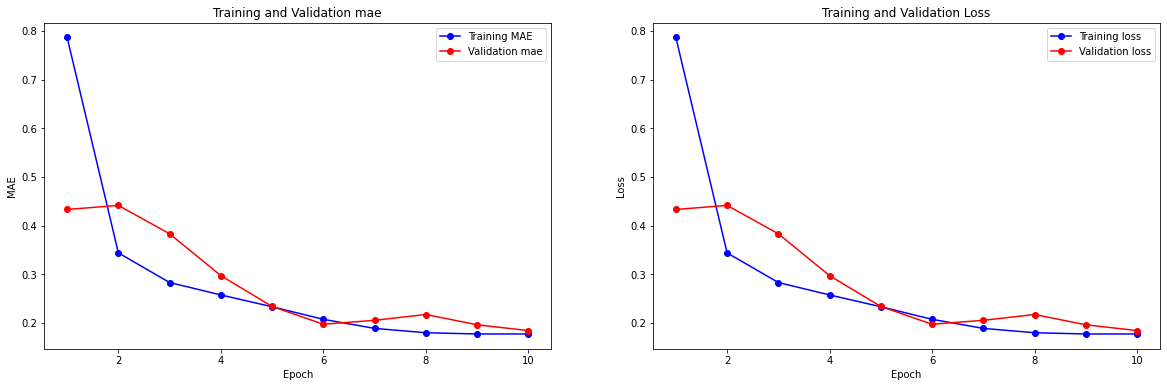

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.2152 - mae: 0.2152
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2406 - mae: 0.2406
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1485 - mae: 0.1485


Training MAE: 107386.45880458519

Validation MAE: 105843.34217682896

In [13]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Given the results, the model seems to be **too simple** for this problem. So we'll build more complex models trying to obtain better performance
</div>

## **Medium complex RNN**
Let's see if we can improve the results, increasing the complexity of the network
### Building the model

In [14]:
model_name = "mid_complex_SimpleRNN_10_10"

In [15]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=10, activation='relu', return_sequences=True)(inputs)
x = SimpleRNN(units=10, activation='relu')(inputs)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)         │ (None, 3, 6)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn_2 (SimpleRNN)           │ (None, 10)                    │         170 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 1)                     │          11 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

### Training

In [16]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=40,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=200, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9235 - mae: 0.9235 - val_loss: 0.2575 - val_mae: 0.2575
Epoch 2/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2730 - mae: 0.2730 - val_loss: 0.1914 - val_mae: 0.1914
Epoch 3/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2055 - mae: 0.2055 - val_loss: 0.1674 - val_mae: 0.1674
Epoch 4/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 0.1907 - mae: 0.1907 - val_loss: 0.1727 - val_mae: 0.1727
Epoch 5/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1853 - mae: 0.1853 - val_loss: 0.1659 - val_mae: 0.1659
Epoch 6/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1810 - mae: 0.1810 - val_loss: 0.2033 - val_mae: 0.2033
Epoch 7/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1826 - mae: 0.1826 - val_loss: 0.1898 - val_mae: 0.1898
Epoch 8/200
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1789 - mae: 0.1789 - val_loss: 0.1801 - val_mae: 0.1801
Epoch 9/200
1080/1080 ━━━━━━━━

### Evaluation

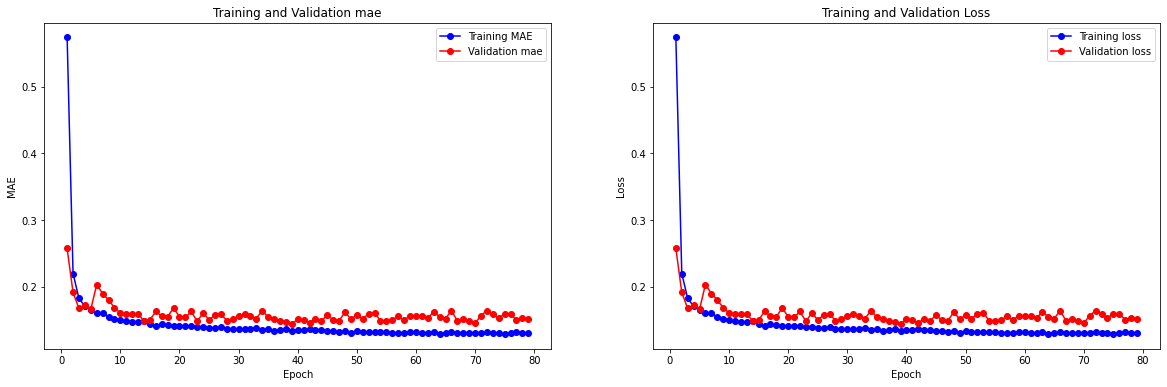

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.1527 - mae: 0.1527
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1867 - mae: 0.1867
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1100 - mae: 0.1100


Training MAE: 78165.96932676049

Validation MAE: 82984.32969785825

In [17]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Given the results, we can observe that this model yielded significantly **better** than the previous one, taking advantage of the added complexity. However, the training and the validation curves are **very close**, and this, considering we are **not** applying regularization yet, may be a symptom that our model would probably **benefit more complexity**.
</div>

## **More complex and Longer training**
In this model, we are going to increase the complexity and the number of epoch, trying to find out if it's complex enough to overfit the data.
### Building Model

In [18]:
model_name = "complex_SimpleRNN"

In [19]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=32, activation='relu', return_sequences=True)(inputs)
x = SimpleRNN(units=64, activation='relu', return_sequences=True)(inputs)
x = SimpleRNN(units=128, activation='relu', return_sequences=True)(inputs)
x = SimpleRNN(units=64, activation='relu')(inputs)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)         │ (None, 3, 6)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn_6 (SimpleRNN)           │ (None, 64)                    │       4,544 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [20]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2835 - mae: 0.2835 - val_loss: 0.3178 - val_mae: 0.3178
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2158 - mae: 0.2158 - val_loss: 0.2103 - val_mae: 0.2103
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1994 - mae: 0.1994 - val_loss: 0.2698 - val_mae: 0.2698
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2030 - mae: 0.2030 - val_loss: 0.2225 - val_mae: 0.2225
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1902 - mae: 0.1902 - val_loss: 0.1947 - val_mae: 0.1947
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1793 - mae: 0.1793 - val_loss: 0.2239 - val_mae: 0.2239
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1769 - mae: 0.1769 - val_loss: 0.2085 - val_mae: 0.2085
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1688 - mae: 0.1688 - val_loss: 0.2170 - val_mae: 0.2170
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

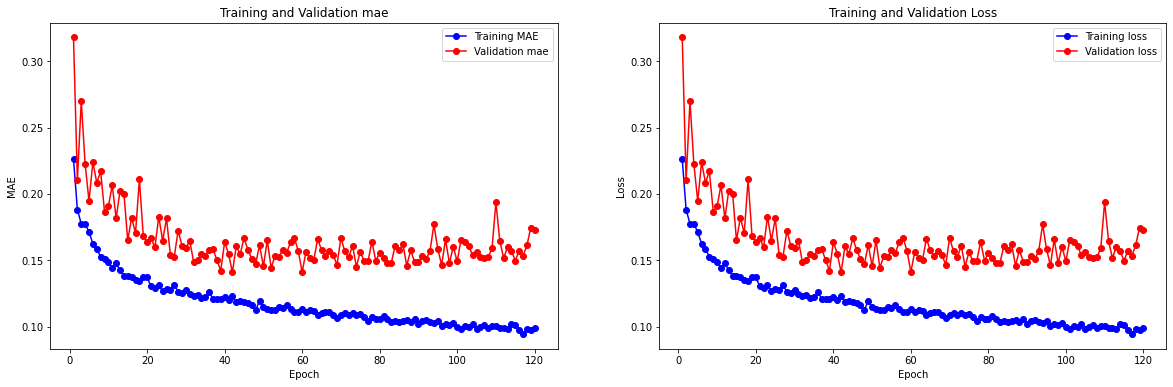

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.1245 - mae: 0.1245
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1696 - mae: 0.1696
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1036 - mae: 0.1036


Training MAE: 65981.99979822677

Validation MAE: 81876.64930606661

In [21]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

As we can see here, now we have obtained a much better value for **training**, although the validation curve does not seem to improve a lot. From here, we're going to apply different **regularization** techniques, trying to avoid this **overfitting** and improve the validation results.
</div>

## **Regularization to avoid overfitting**

## Dropout
### Building model

In [22]:
model_name = "complex_SimpleRNN_dropOut"

In [10]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=32, activation='relu', return_sequences=True, 
              dropout=0.1, recurrent_dropout=0.1)(inputs)

x = SimpleRNN(units=64, activation='relu', return_sequences=True, 
              dropout=0.1, recurrent_dropout=0.1)(x)

x = SimpleRNN(units=128, activation='relu', return_sequences=True, 
             dropout=0.1, recurrent_dropout=0.1)(x)

x = SimpleRNN(units=64, activation='relu', dropout=0.1, recurrent_dropout=0.1)(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 3, 32)             │      1,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 3, 64)             │      6,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 3, 128)            │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)                │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,577 (174.13 KB)

 Trainable params: 44,577 (174.13 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [24]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.5907 - mae: 0.5907 - val_loss: 0.5534 - val_mae: 0.5534
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4079 - mae: 0.4079 - val_loss: 0.5183 - val_mae: 0.5183
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4007 - mae: 0.4007 - val_loss: 0.5102 - val_mae: 0.5102
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3644 - mae: 0.3644 - val_loss: 0.4948 - val_mae: 0.4948
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3798 - mae: 0.3798 - val_loss: 0.4623 - val_mae: 0.4623
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3492 - mae: 0.3492 - val_loss: 0.4910 - val_mae: 0.4910
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3392 - mae: 0.3392 - val_loss: 0.4684 - val_mae: 0.4684
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3250 - mae: 0.3250 - val_loss: 0.4504 - val_mae: 0.4504
Epoch 9/500
1080/1080 ━━━━━━━━━

### Evaluation

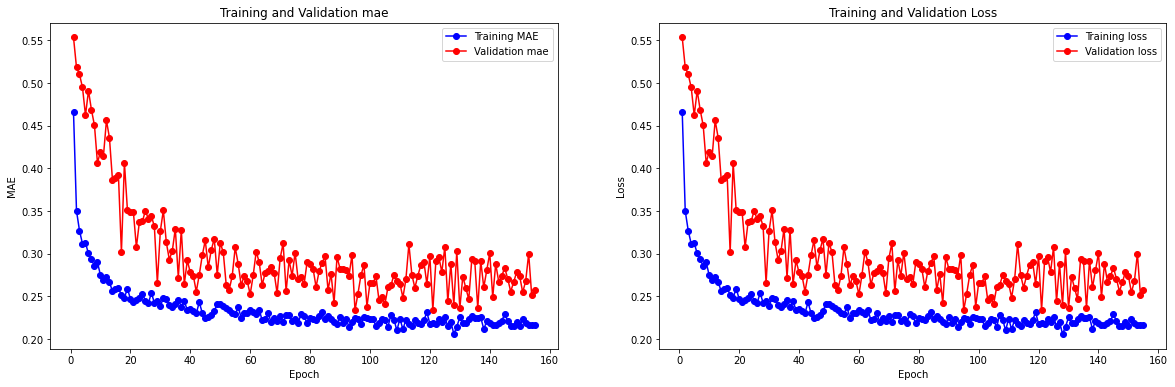

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - loss: 0.2556 - mae: 0.2556
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2967 - mae: 0.2967
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2510 - mae: 0.2510


Training MAE: 126801.97989308194

Validation MAE: 133324.00856051265

In [25]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

After testing various **DropOut** regularization configurations, we have come to the conclusion that this method **does not appear to be effective**. The model is extremely sensitive to regularization, and even when using very low drop out probabilities, the model's performance in fitting not only the validation data but also the training data is significantly **limited**, **worsening the outcomes considerably**. Therefore, we are considering the use of other, less intensive regularization methods to see if they offer better performance; in this case, we will test with L2 regularization.
</div>

## L2 Regularization
### Building model

In [26]:
model_name = "complex_SimpleRNN_L2"

In [11]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001))(inputs)

x = SimpleRNN(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001))(x)

x = SimpleRNN(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001))(x)

x = SimpleRNN(units=64, activation='relu', kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 3, 32)             │      1,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 3, 64)             │      6,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 3, 128)            │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)                │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,577 (174.13 KB)

 Trainable params: 44,577 (174.13 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [28]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5114 - mae: 0.4701 - val_loss: 0.4101 - val_mae: 0.3749
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2855 - mae: 0.2517 - val_loss: 0.4000 - val_mae: 0.3703
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2563 - mae: 0.2279 - val_loss: 0.4164 - val_mae: 0.3919
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2589 - mae: 0.2354 - val_loss: 0.3581 - val_mae: 0.3378
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2248 - mae: 0.2053 - val_loss: 0.3784 - val_mae: 0.3614
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2242 - mae: 0.2078 - val_loss: 0.2875 - val_mae: 0.2729
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2000 - mae: 0.1858 - val_loss: 0.3321 - val_mae: 0.3192
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1942 - mae: 0.1816 - val_loss: 0.3044 - val_mae: 0.2925
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

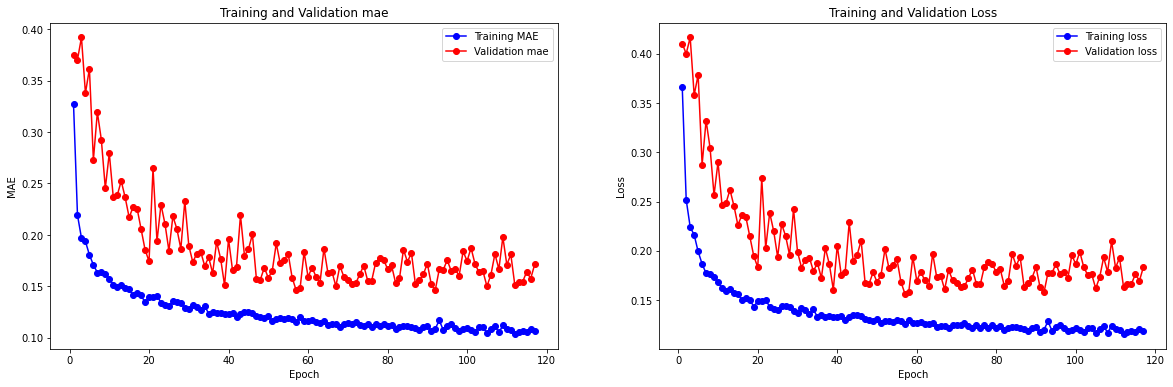

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.1603 - mae: 0.1499
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1877 - mae: 0.1773
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1402 - mae: 0.1298


Training MAE: 72191.68498815331

Validation MAE: 84342.2623778477

In [29]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Once again, we have encountered a model that is very sensitive to L2 regularization, resulting in a drastic deterioration of the outcomes. However, in the case of L2 regularization, it appears that the model could benefit from regularization by using very low L2 regularization terms. In the next experiment, we will test the use of very light L2 regularization.
</div>

## L2 very slight regularization
### Building the Model

In [65]:
model_name = "complex_SimpleRNN_low_L2"

In [12]:
inputs = Input(shape=(seqLength, nFeatures))

x = SimpleRNN(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(inputs)

x = SimpleRNN(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = SimpleRNN(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = SimpleRNN(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 3, 32)             │      1,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 3, 64)             │      6,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 3, 128)            │     24,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)                │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,577 (174.13 KB)

 Trainable params: 44,577 (174.13 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [67]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4434 - mae: 0.4387 - val_loss: 0.4159 - val_mae: 0.4114
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2566 - mae: 0.2520 - val_loss: 0.4245 - val_mae: 0.4200
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2383 - mae: 0.2338 - val_loss: 0.3383 - val_mae: 0.3338
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2105 - mae: 0.2061 - val_loss: 0.2999 - val_mae: 0.2956
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2002 - mae: 0.1960 - val_loss: 0.3426 - val_mae: 0.3385
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2010 - mae: 0.1969 - val_loss: 0.3091 - val_mae: 0.3052
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1821 - mae: 0.1782 - val_loss: 0.2577 - val_mae: 0.2540
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1904 - mae: 0.1868 - val_loss: 0.3472 - val_mae: 0.3437
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

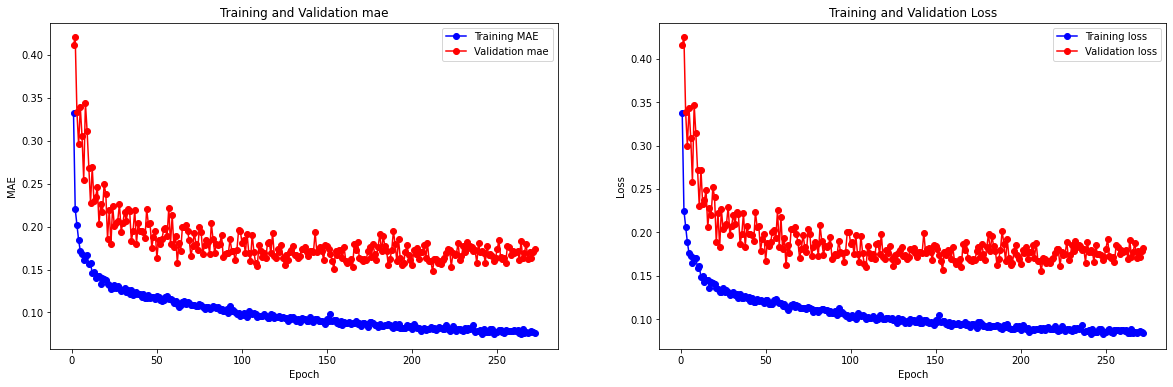

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 0.1116 - mae: 0.1042
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1863 - mae: 0.1789
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1221 - mae: 0.1147


Training MAE: 50279.74117459386

Validation MAE: 84404.98846393568

In [68]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this case, the results obtained (**50279** in train) indicate that the model has regained its fitting capacity by using **lighter regularizations**, yet the validation metric has not improved significantly (**84404**). Moreover, it is noteworthy that the **best MAE** achieved in validation by models implementing SimpleRNN was the one that **did not use regularization** beyond **Early Stopping**. This method proves to be particularly useful in this case, as it helps to prevent overfitting before it occurs, avoiding the use of other techniques that, in this instance, seem to negatively affect the model's learning capacity. In the next steps, we'll use **LSTMs** trying to improve the capabilities and performance of our models.
</div>

## **Complex LSTM**
### Building the model

In [69]:
model_name = "complex_LSTM"

In [70]:
inputs = Input(shape=(seqLength, nFeatures))

x = LSTM(units=32, activation='relu', return_sequences=True)(inputs)
x = LSTM(units=64, activation='relu', return_sequences=True)(inputs)
x = LSTM(units=128, activation='relu', return_sequences=True)(inputs)
x = LSTM(units=64, activation='relu')(inputs)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)        │ (None, 3, 6)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_25 (LSTM)                     │ (None, 64)                    │      18,176 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_16 (Dense)                   │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [71]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4600 - mae: 0.4600 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2045 - mae: 0.2045 - val_loss: 0.1872 - val_mae: 0.1872
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1974 - mae: 0.1974 - val_loss: 0.1686 - val_mae: 0.1686
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1870 - mae: 0.1870 - val_loss: 0.1790 - val_mae: 0.1790
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1802 - mae: 0.1802 - val_loss: 0.1939 - val_mae: 0.1939
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1833 - mae: 0.1833 - val_loss: 0.1946 - val_mae: 0.1946
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1738 - mae: 0.1738 - val_loss: 0.1878 - val_mae: 0.1878
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1743 - mae: 0.1743 - val_loss: 0.1912 - val_mae: 0.1912
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

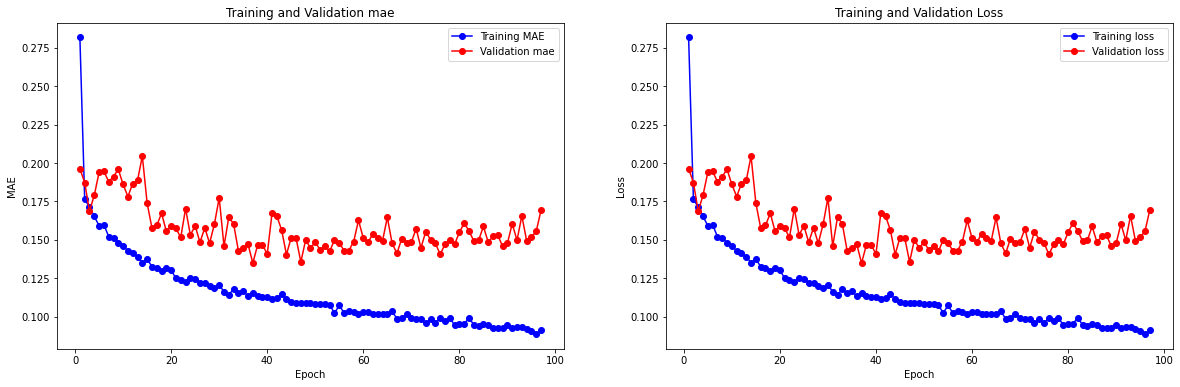

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - loss: 0.1417 - mae: 0.1417
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1675 - mae: 0.1675
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1183 - mae: 0.1183


Training MAE: 70628.29027197293

Validation MAE: 77620.18116639928

In [72]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Upon reviewing the results, several aspects can be observed: The MAE on the training set is **higher** than that obtained in previous experiments using SimpleRNN, and it can be noted that while overfitting is present, it is also being **mitigated** by using **Early Stopping**. On the other hand, it is worth mentioning that the **MAE** obtained in **validation is the best so far**, which makes LSTMs appear promising at this point. Consequently, we will employ some regularization methods in an attempt to reduce overfitting and further decrease the MAE in validation.
</div>

## **LSTM with L2 Regularization**
### Building the model

In [73]:
model_name = "complex_LSTM_L2"

In [23]:
inputs = Input(shape=(seqLength, nFeatures))

x = LSTM(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(inputs)

x = LSTM(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 32)             │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 64)             │     24,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 128)            │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)                │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 178,113 (695.75 KB)

 Trainable params: 178,113 (695.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [75]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7613 - mae: 0.7581 - val_loss: 0.4572 - val_mae: 0.4540
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3006 - mae: 0.2973 - val_loss: 0.3801 - val_mae: 0.3766
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2498 - mae: 0.2463 - val_loss: 0.3396 - val_mae: 0.3360
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2382 - mae: 0.2345 - val_loss: 0.2597 - val_mae: 0.2561
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2245 - mae: 0.2209 - val_loss: 0.2210 - val_mae: 0.2173
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2151 - mae: 0.2114 - val_loss: 0.2261 - val_mae: 0.2225
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2026 - mae: 0.1990 - val_loss: 0.2599 - val_mae: 0.2563
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2146 - mae: 0.2110 - val_loss: 0.2166 - val_mae: 0.2131
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

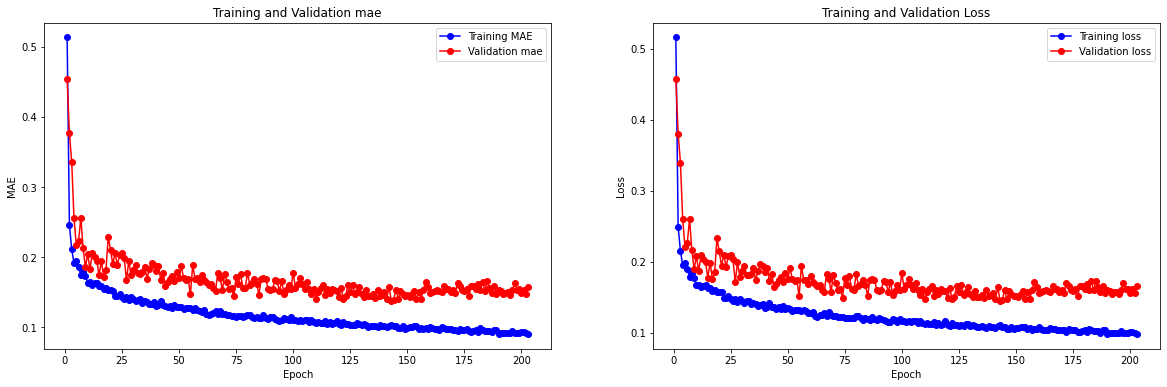

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 0.1293 - mae: 0.1230
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1873 - mae: 0.1810
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1166 - mae: 0.1103


Training MAE: 61934.901741831905

Validation MAE: 80626.94936797292

In [76]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

As we expected and similar to previous occurrences, the model has proven to be **extremely sensitive to regularization**. Again, the use of **DropOut,** **L1 Regularization**, or average **L2 regularization** values has resulted in a **significant deterioration** of the results obtained both in training and validation. Finally, we present here the results obtained with **very slight L2 regularization**, which, while offering **acceptable** values, are still slightly worse than those obtained without applying any regularization during training, beyond Early Stopping. However, even though the final results are slightly worse, it is noteworthy that the use of L2 regularization has produced a **notably more stable training**, which could be beneficial. Next, we are training a more complex LSTMs model with the same regularization, trying to find if this added complexity can help on improving the results by increasing its learning capabilities.
</div>

## **More complex LSTM with L2 Regularization**
### Building the Model

In [77]:
model_name = "very_complex_LSTM_L2"

In [13]:
inputs = Input(shape=(seqLength, nFeatures))

x = LSTM(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(inputs)

x = LSTM(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=256, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm (LSTM)                     │ (None, 3, 32)             │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)             │     24,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 128)            │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)            │    394,240 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)                │     82,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 605,121 (2.31 MB)

 Trainable params: 605,121 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [79]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9104 - mae: 0.9062 - val_loss: 0.8097 - val_mae: 0.8078
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9719 - mae: 0.9702 - val_loss: 0.7410 - val_mae: 0.7383
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5551 - mae: 0.5512 - val_loss: 0.3301 - val_mae: 0.3260
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2439 - mae: 0.2398 - val_loss: 0.2740 - val_mae: 0.2701
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2373 - mae: 0.2334 - val_loss: 0.2776 - val_mae: 0.2737
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2187 - mae: 0.2149 - val_loss: 0.2441 - val_mae: 0.2404
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2117 - mae: 0.2080 - val_loss: 0.2304 - val_mae: 0.2268
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2072 - mae: 0.2035 - val_loss: 0.2729 - val_mae: 0.2692
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

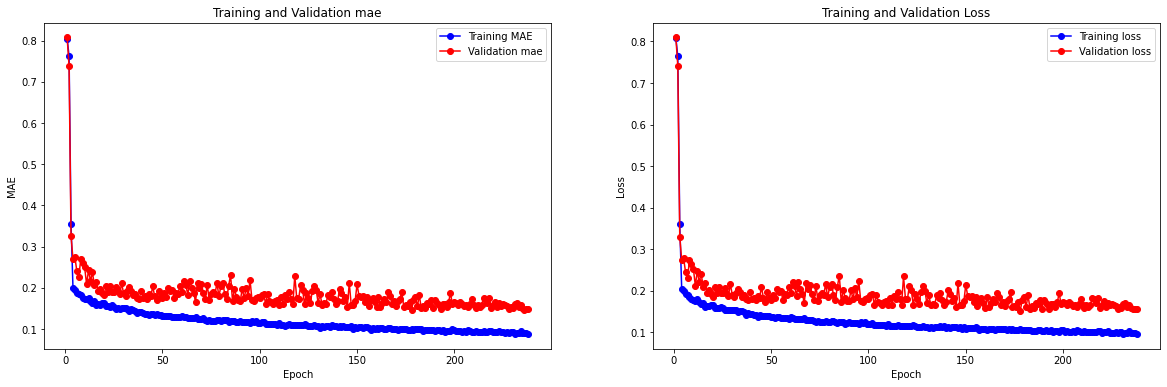

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1311 - mae: 0.1244
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2024 - mae: 0.1957
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1364 - mae: 0.1297


Training MAE: 61234.06149177272

Validation MAE: 84296.36105647296

In [80]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Given the results of this slightly more complex model, it can be seen that there is **no significant improvement**, and, in fact, the **results worsen slightly**. Therefore, we conclude that the **complexities used so far seem to be sufficient**, and increasing them offers no benefit. Next, we're going to explore the usage and benefits of GRU models.

</div>

## **Simple GRU**
### Building Model

In [81]:
model_name = "simple_GRU"

In [14]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.GRU(10, activation='relu',return_sequences=True)(inputs)
x = layers.GRU(10, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru (GRU)                       │ (None, 3, 10)             │        540 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_1 (GRU)                     │ (None, 10)                │        660 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 1)                 │         11 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,211 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [83]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7475 - mae: 0.7475 - val_loss: 0.2170 - val_mae: 0.2170
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2150 - mae: 0.2150 - val_loss: 0.1972 - val_mae: 0.1972
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1914 - mae: 0.1914 - val_loss: 0.2484 - val_mae: 0.2484
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1868 - mae: 0.1868 - val_loss: 0.1989 - val_mae: 0.1989
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1835 - mae: 0.1835 - val_loss: 0.1746 - val_mae: 0.1746
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1779 - mae: 0.1779 - val_loss: 0.1928 - val_mae: 0.1928
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1788 - mae: 0.1788 - val_loss: 0.1727 - val_mae: 0.1727
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1745 - mae: 0.1745 - val_loss: 0.1737 - val_mae: 0.1737
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

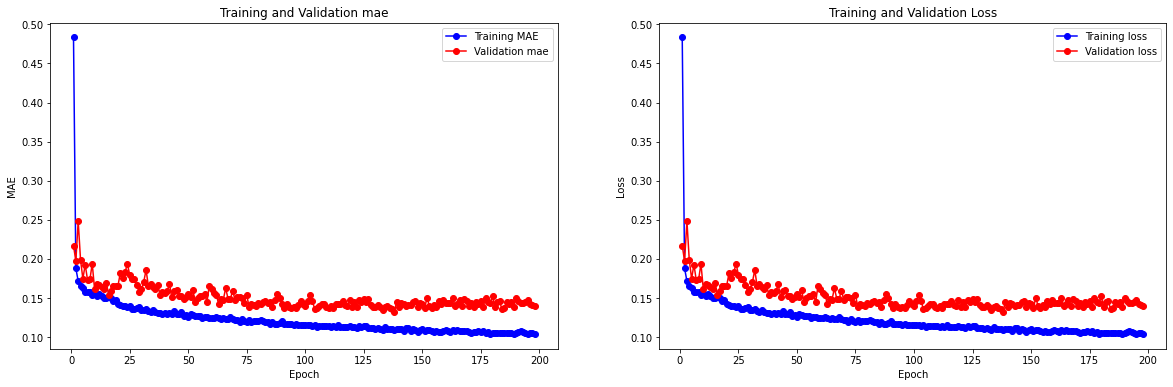

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - loss: 0.1425 - mae: 0.1425
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1670 - mae: 0.1670
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1367 - mae: 0.1367


Training MAE: 68441.88163960069

Validation MAE: 76218.45776784972

In [84]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this first GRU model, a good MAE result is obtained for the training set and a slightly worse result for the validation set. Still the results are good considering the simplicity of the model.
</div>

## **Medium Complex GRU**
### Building Model

In [85]:
model_name = "mid_complex_GRU"

In [15]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.GRU(10, activation='relu',return_sequences=True)(inputs)
x = layers.GRU(10, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_2 (GRU)                     │ (None, 3, 10)             │        540 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_3 (GRU)                     │ (None, 10)                │        660 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 32)                │        352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,585 (6.19 KB)

 Trainable params: 1,585 (6.19 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [87]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6531 - mae: 0.6531 - val_loss: 0.2153 - val_mae: 0.2153
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2156 - mae: 0.2156 - val_loss: 0.2180 - val_mae: 0.2180
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2019 - mae: 0.2019 - val_loss: 0.2264 - val_mae: 0.2264
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1969 - mae: 0.1969 - val_loss: 0.1890 - val_mae: 0.1890
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1850 - mae: 0.1850 - val_loss: 0.2121 - val_mae: 0.2121
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1886 - mae: 0.1886 - val_loss: 0.1777 - val_mae: 0.1777
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1840 - mae: 0.1840 - val_loss: 0.1798 - val_mae: 0.1798
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1836 - mae: 0.1836 - val_loss: 0.2431 - val_mae: 0.2431
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

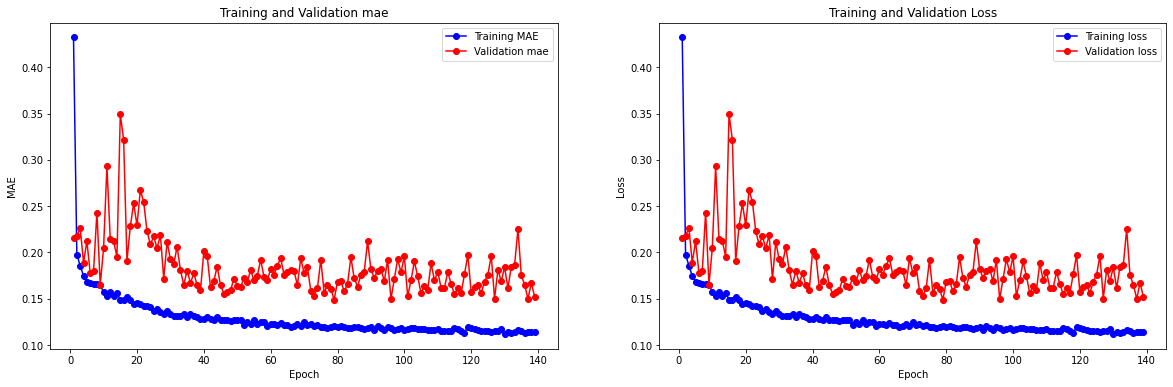

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 0.1515 - mae: 0.1515
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1997 - mae: 0.1997
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1410 - mae: 0.1410


Training MAE: 74528.59418667413

Validation MAE: 85812.65758504836

In [88]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this second model, training and validation results are **slightly worse** than in the previous model, so adding a dense layer does not seem to have helped to improve the results.
</div>

## **Complex GRU - Low L2 Regularization**

### Building Model

In [89]:
model_name = "complex_GRU_L2"

In [16]:
inputs = Input(shape=(seqLength, nFeatures))

x = layers.GRU(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(inputs)

x = layers.GRU(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = layers.GRU(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = layers.GRU(units=256, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = layers.GRU(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_4 (GRU)                     │ (None, 3, 32)             │      3,840 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_5 (GRU)                     │ (None, 3, 64)             │     18,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_6 (GRU)                     │ (None, 3, 128)            │     74,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_7 (GRU)                     │ (None, 3, 256)            │    296,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_8 (GRU)                     │ (None, 64)                │     61,824 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 455,489 (1.74 MB)

 Trainable params: 455,489 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [91]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6142 - mae: 0.6092 - val_loss: 0.3428 - val_mae: 0.3393
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2600 - mae: 0.2564 - val_loss: 0.3374 - val_mae: 0.3339
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2497 - mae: 0.2462 - val_loss: 0.3764 - val_mae: 0.3731
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2493 - mae: 0.2459 - val_loss: 0.2703 - val_mae: 0.2670
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2108 - mae: 0.2075 - val_loss: 0.2725 - val_mae: 0.2694
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2206 - mae: 0.2174 - val_loss: 0.2730 - val_mae: 0.2699
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2066 - mae: 0.2034 - val_loss: 0.2321 - val_mae: 0.2290
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1975 - mae: 0.1944 - val_loss: 0.3306 - val_mae: 0.3276
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

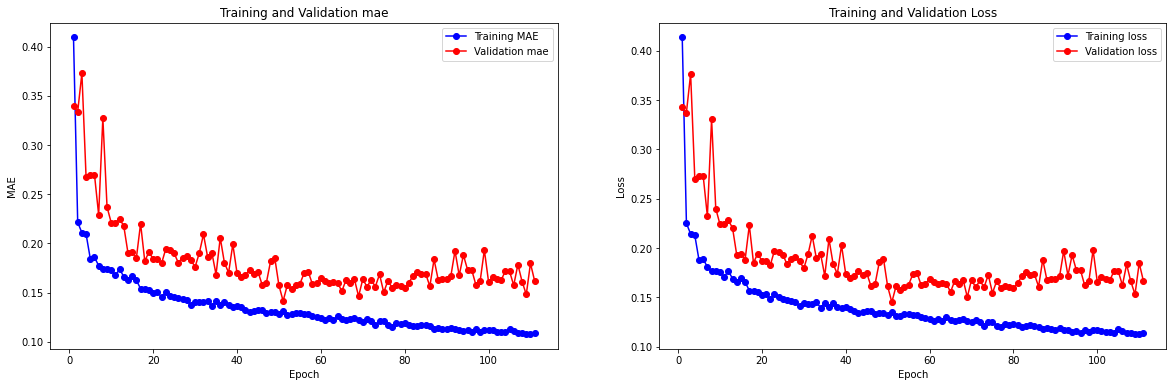

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 0.1762 - mae: 0.1725
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1921 - mae: 0.1883
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1524 - mae: 0.1487


Training MAE: 81033.05165668887

Validation MAE: 81313.28994828943

In [92]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this model we have decided to try a model with some more layer, but adding a rather **low L2 regularization**, which in other previous models has obtained acceptable results, in comparison with **Dropout**, which obtains much worse results. The result obtained is within what we expected, and comparing with the two previous models, this is the one that seems to work worse. Once more, the model seems **too sensitive to regularization**, slightly worsening the results.

</div>

## **Bidirectional**
## GRU
### Building the Model

In [17]:
model_name = "bidirectional_SimpleGRU"

In [18]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.Bidirectional(layers.GRU(10, activation='relu',return_sequences=True))(inputs)
x = layers.Bidirectional(layers.GRU(10, activation='relu'))(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 20)             │      1,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20)                │      1,920 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 1)                 │         21 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,021 (11.80 KB)

 Trainable params: 3,021 (11.80 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [19]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6290 - mae: 0.6290 - val_loss: 0.2748 - val_mae: 0.2748
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2224 - mae: 0.2224 - val_loss: 0.2404 - val_mae: 0.2404
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2153 - mae: 0.2153 - val_loss: 0.2060 - val_mae: 0.2060
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1934 - mae: 0.1934 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1893 - mae: 0.1893 - val_loss: 0.1716 - val_mae: 0.1716
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1860 - mae: 0.1860 - val_loss: 0.1809 - val_mae: 0.1809
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1840 - mae: 0.1840 - val_loss: 0.1750 - val_mae: 0.1750
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1825 - mae: 0.1825 - val_loss: 0.1603 - val_mae: 0.1603
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

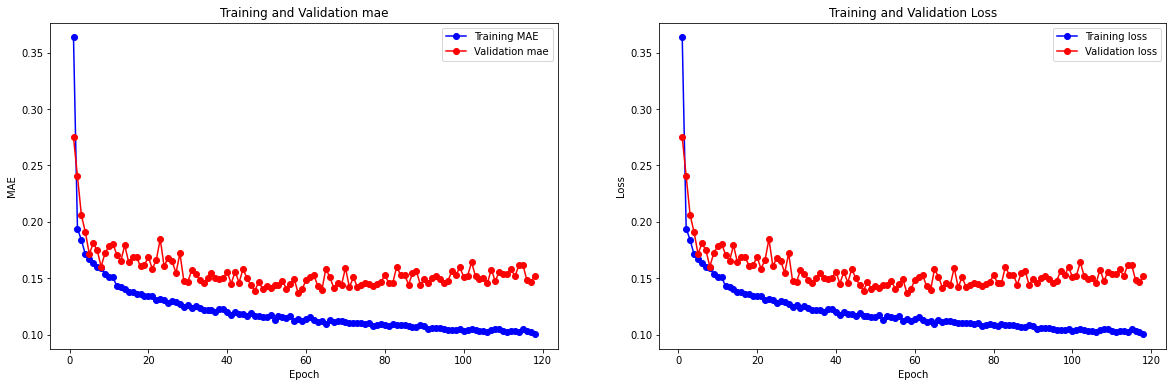

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.1380 - mae: 0.1380
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1685 - mae: 0.1685
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1127 - mae: 0.1127


Training MAE: 70881.4467839624

Validation MAE: 78487.61318414693

In [20]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this model, we have tried to add bidirectional layers with the simple GRU model, the result obtained in both training and validation is within **acceptable** parameters. However, if we compare these results with the simple GRU model, it seems that the bidirectional one performs **worse** in the training and validation set.

</div>

## LSTM
### Building the model

In [26]:
model_name = "bidirectional_complex_LSTM_L2"

In [24]:
inputs = Input(shape=(seqLength, nFeatures))

x = layers.Bidirectional(LSTM(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001)))(inputs)

x = layers.Bidirectional(LSTM(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001)))(x)

x = layers.Bidirectional(LSTM(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001)))(x)

x = layers.Bidirectional(LSTM(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001)))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 3, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_10                │ (None, 3, 64)             │      9,984 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_11                │ (None, 3, 128)            │     66,048 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_12                │ (None, 3, 256)            │    263,168 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_13                │ (None, 128)               │    164,352 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 503,681 (1.92 MB)

 Trainable params: 503,681 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [27]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5141 - mae: 0.5074 - val_loss: 0.5014 - val_mae: 0.4959
Epoch 2/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2715 - mae: 0.2660 - val_loss: 0.3346 - val_mae: 0.3294
Epoch 3/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2515 - mae: 0.2463 - val_loss: 0.3169 - val_mae: 0.3117
Epoch 4/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2354 - mae: 0.2302 - val_loss: 0.3430 - val_mae: 0.3379
Epoch 5/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2245 - mae: 0.2194 - val_loss: 0.2344 - val_mae: 0.2295
Epoch 6/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2064 - mae: 0.2015 - val_loss: 0.2193 - val_mae: 0.2148
Epoch 7/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2166 - mae: 0.2118 - val_loss: 0.2765 - val_mae: 0.2718
Epoch 8/500
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2074 - mae: 0.2026 - val_loss: 0.2531 - val_mae: 0.2486
Epoch 9/500
1080/1080 ━━━━━━━━━━

### Evaluation

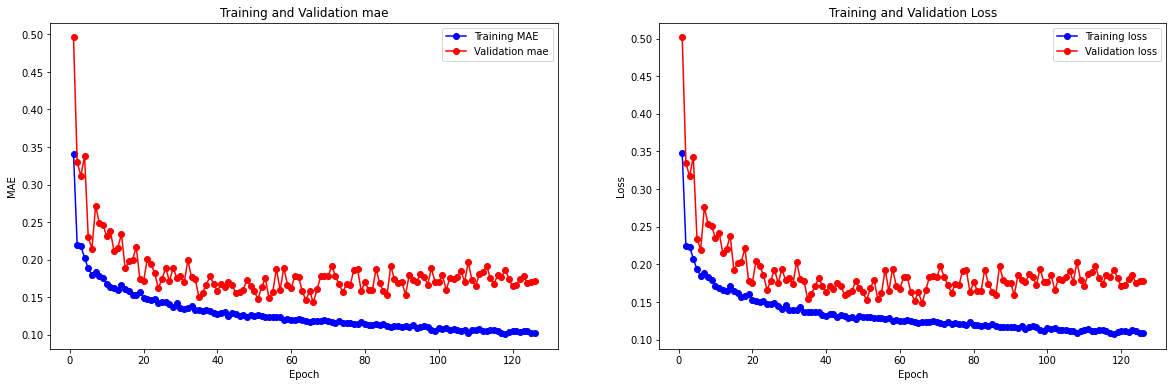

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1427 - mae: 0.1376
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1873 - mae: 0.1821
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1102 - mae: 0.1050


Training MAE: 71504.70093136893

Validation MAE: 83629.84813105308

In [28]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this model we have done the same as before, applying bidirectional layers but in this case to the **LSTM model with L2 regularization**. The results obtained are also within acceptable parameters, and if we compare these results with their homogeneous ones without the bidirectional layer, it seems that the results are somewhat **worse** than those of the model without bidirectional layers.

Next, we will try to increase the size of the time series sequences, trying to determine if increasing the contextual information we can obtain better results.

</div>

## **Increasing sequence Length to four**

In [45]:
seqLength = 4
trainData, valData, testData, stdSales, nFeatures = generateTrainTestData("./data/walmart-sales-dataset-of-45stores.csv",
    valPercent, testPercent, seqLength, batchSize)

## GRU
### Building Model

In [60]:
model_name = "seq4_SimpleGRU"

In [47]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.GRU(10, activation='relu',return_sequences=True)(inputs)
x = layers.GRU(10, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 4, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_13 (GRU)                    │ (None, 4, 10)             │        540 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_14 (GRU)                    │ (None, 10)                │        660 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 1)                 │         11 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,211 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [48]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5890 - mae: 0.5890 - val_loss: 0.2145 - val_mae: 0.2145
Epoch 2/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2309 - mae: 0.2309 - val_loss: 0.1680 - val_mae: 0.1680
Epoch 3/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2020 - mae: 0.2020 - val_loss: 0.1797 - val_mae: 0.1797
Epoch 4/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1977 - mae: 0.1977 - val_loss: 0.1664 - val_mae: 0.1664
Epoch 5/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1871 - mae: 0.1871 - val_loss: 0.1740 - val_mae: 0.1740
Epoch 6/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1806 - mae: 0.1806 - val_loss: 0.1672 - val_mae: 0.1672
Epoch 7/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1748 - mae: 0.1748 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 8/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1732 - mae: 0.1732 - val_loss: 0.1306 - val_mae: 0.1306
Epoch 9/500
1035/1035 ━━━━━━━━━━

### Evaluation

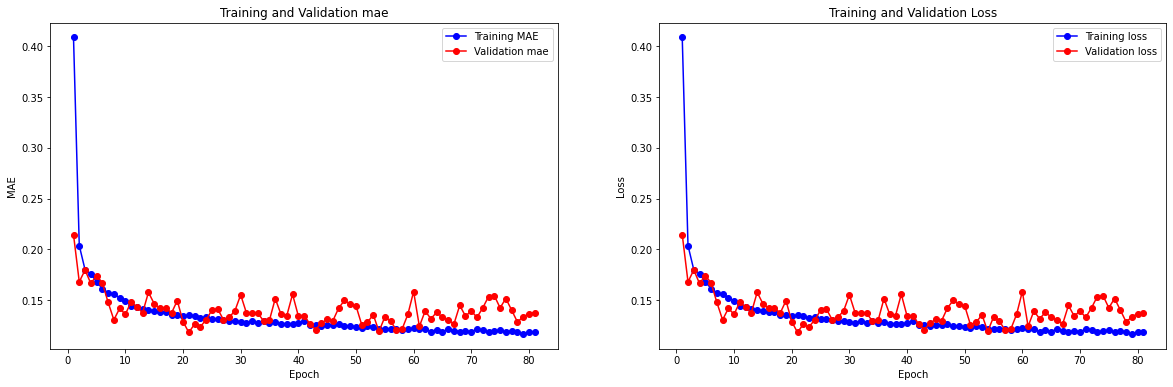

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - loss: 0.1622 - mae: 0.1622
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1543 - mae: 0.1543
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1331 - mae: 0.1331


Training MAE: 83504.03561205512

Validation MAE: 76949.06952915569

In [49]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Now we have extended the **sequence size to 4**, and we have tested on a simple GRU model how it works. In this case, for the simple model, the validation result is better than the train result, which was not the case before. Also, the MAE value obtained is somewhat worse than the simple GRU model with a sequence size of three.

</div>

## LSTM
### Building the model

In [59]:
model_name = "seq4_complex_LSTM_L2"

In [51]:
inputs = Input(shape=(seqLength, nFeatures))

x = LSTM(units=32, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(inputs)

x = LSTM(units=64, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=128, activation='relu', return_sequences=True, 
              kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

x = LSTM(units=64, activation='relu', kernel_regularizer=l2(0.00001), recurrent_regularizer=l2(0.00001))(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 4, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_25 (LSTM)                  │ (None, 4, 32)             │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_26 (LSTM)                  │ (None, 4, 64)             │     24,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_27 (LSTM)                  │ (None, 4, 128)            │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_28 (LSTM)                  │ (None, 64)                │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 178,113 (695.75 KB)

 Trainable params: 178,113 (695.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [52]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7407 - mae: 0.7373 - val_loss: 0.3532 - val_mae: 0.3500
Epoch 2/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2616 - mae: 0.2584 - val_loss: 0.3232 - val_mae: 0.3199
Epoch 3/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2467 - mae: 0.2433 - val_loss: 0.3157 - val_mae: 0.3124
Epoch 4/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2329 - mae: 0.2296 - val_loss: 0.2687 - val_mae: 0.2653
Epoch 5/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2141 - mae: 0.2107 - val_loss: 0.2587 - val_mae: 0.2554
Epoch 6/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2134 - mae: 0.2100 - val_loss: 0.2823 - val_mae: 0.2789
Epoch 7/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2024 - mae: 0.1990 - val_loss: 0.2538 - val_mae: 0.2504
Epoch 8/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2072 - mae: 0.2038 - val_loss: 0.2464 - val_mae: 0.2429
Epoch 9/500
1035/1035 ━━━━━━━━━━

### Evaluation

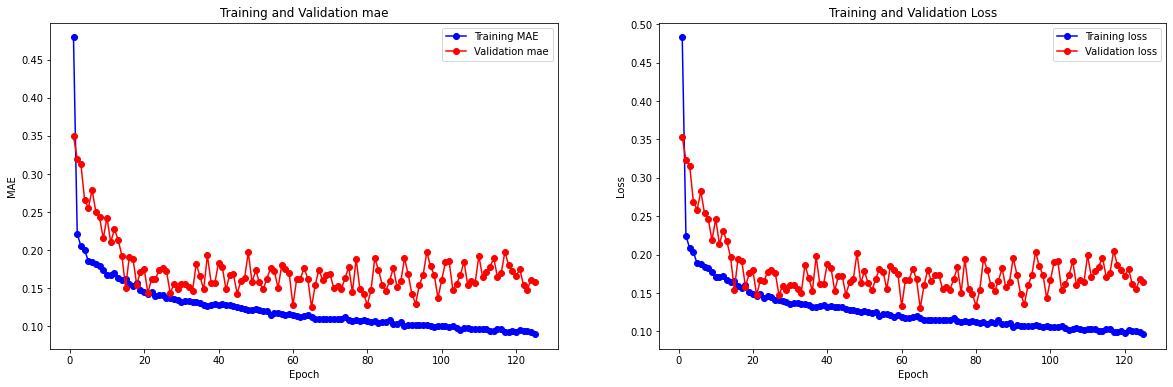

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1457 - mae: 0.1401
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1738 - mae: 0.1682
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 - mae: 0.1440


Training MAE: 70883.92202344214

Validation MAE: 77796.51087796818

In [53]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

The same LSTM model that we have tested previously, we have now tested for sequence 4, and it seems to **perform better** than the two LSTM models tested previously with sequence 3 (both in train and validation).
</div>

## Bidirectional
### Building the model

In [55]:
model_name = "seq4_bidirectional_SimpleGRU"

In [56]:
inputs = keras.Input(shape=(seqLength, nFeatures))
x = layers.Bidirectional(layers.GRU(10, activation='relu',return_sequences=True))(inputs)
x = layers.Bidirectional(layers.GRU(10, activation='relu'))(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 4, 6)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_14                │ (None, 4, 20)             │      1,080 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional_15                │ (None, 20)                │      1,920 │
│ (Bidirectional)                 │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │         21 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,021 (11.80 KB)

 Trainable params: 3,021 (11.80 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [57]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=60,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5705 - mae: 0.5705 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 2/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2071 - mae: 0.2071 - val_loss: 0.1921 - val_mae: 0.1921
Epoch 3/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1997 - mae: 0.1997 - val_loss: 0.1830 - val_mae: 0.1830
Epoch 4/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1947 - mae: 0.1947 - val_loss: 0.1501 - val_mae: 0.1501
Epoch 5/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1904 - mae: 0.1904 - val_loss: 0.1701 - val_mae: 0.1701
Epoch 6/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1881 - mae: 0.1881 - val_loss: 0.1611 - val_mae: 0.1611
Epoch 7/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1831 - mae: 0.1831 - val_loss: 0.1555 - val_mae: 0.1555
Epoch 8/500
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1838 - mae: 0.1838 - val_loss: 0.1374 - val_mae: 0.1374
Epoch 9/500
1035/1035 ━━━━━━━━━━

### Evaluation

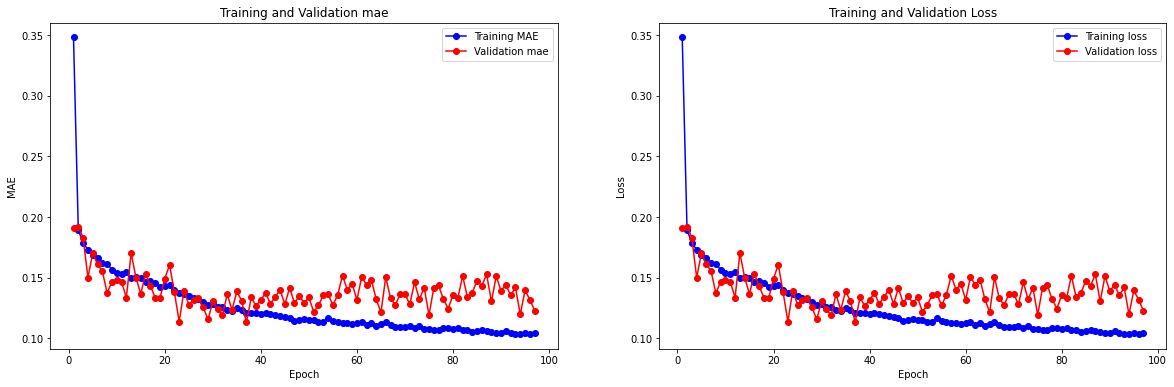

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 0.1478 - mae: 0.1478
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1428 - mae: 0.1428
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1281 - mae: 0.1281


Training MAE: 75038.26186797224

Validation MAE: 67436.9387006692

In [58]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

Finally, we have also tested a model with bidirectional layers using sequence 4. After seeing the results, the MAE in validation seems to be a little better than in the previous bidirectional models, although the results obtained are **quite similar**.
</div>

## **Increase sequences to twelve**

In [181]:
valPercent = 0.2
batchSize = 1
seqLength = 8

trainData, valData, testData, stdSales, nFeatures = generateTrainTestData("./data/walmart-sales-dataset-of-45stores.csv",
    valPercent, testPercent, seqLength, batchSize) 

## Bidirectional GRU
### Building the model

In [172]:
inputs = Input(shape=(seqLength, nFeatures))

x = layers.GRU(units=256, return_sequences=True)(inputs)

x = layers.GRU(units=128, return_sequences=True)(x)

x = layers.GRU(units=64, return_sequences=True)(x)

x = layers.GRU(units=32)(x)

x = Dense(64)(x)
x = Dense(16)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 13, 6)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_102 (GRU)                   │ (None, 13, 256)           │    202,752 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_103 (GRU)                   │ (None, 13, 128)           │    148,224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_104 (GRU)                   │ (None, 13, 64)            │     37,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_105 (GRU)                   │ (None, 32)                │      9,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_88 (Dense)                │ (None, 64)                │      2,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_89 (Dense)                │ (None, 16)                │      1,040 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_90 (Dense)                │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 400,801 (1.53 MB)

 Trainable params: 400,801 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [173]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    trainData, 
    epochs=500, 
    batch_size=batchSize, 
    validation_data=valData, 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3070 - mae: 0.3070 - val_loss: 0.5851 - val_mae: 0.5851
Epoch 2/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3035 - mae: 0.3035 - val_loss: 0.5480 - val_mae: 0.5480
Epoch 3/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3110 - mae: 0.3110 - val_loss: 0.7028 - val_mae: 0.7028
Epoch 4/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3953 - mae: 0.3953 - val_loss: 0.6103 - val_mae: 0.6103
Epoch 5/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3121 - mae: 0.3121 - val_loss: 0.5519 - val_mae: 0.5519
Epoch 6/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3021 - mae: 0.3021 - val_loss: 0.4640 - val_mae: 0.4640
Epoch 7/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2813 - mae: 0.2813 - val_loss: 0.4792 - val_mae: 0.4792
Epoch 8/500
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2882 - mae: 0.2882 - val_loss: 0.3818 - val_mae: 0.3818
Epoch 9/500
2610/2610 ━━━━━━━━━━

### Evaluation

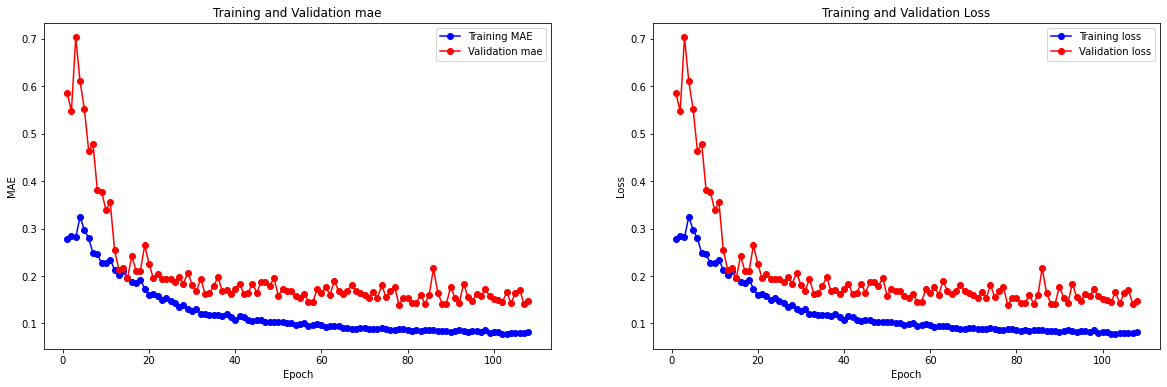

2610/2610 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - loss: 0.1932 - mae: 0.1932
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1413 - mae: 0.1413
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1387 - mae: 0.1387


Training MAE: 79625.34688349368

Validation MAE: 77423.76893462213

In [175]:
plot(history)
train_MAE = model.evaluate(trainData)[-1] * stdSales
val_MAE = model.evaluate(valData)[-1] * stdSales
test_MAE = model.evaluate(testData)[-1] * stdSales
print(f"Training MAE: {train_MAE}")
print(f"Validation MAE: {val_MAE}")

save_model_results(val_results_path, model_name, val_MAE)
save_model_results(test_results_path, model_name, test_MAE)

In [182]:
len(trainData), len(valData), len(testData)

(3060, 495, 585)

# **Results summary and discussion**

## Obtaining the results

All the results have been saved previously for each model for both datasets. In this section, we collect all those results and create several dictionaries to use the utility function `plot_results_grouped`. This allows a clear comparison between the different models.

In [65]:
val_results_path = os.path.join('.','val_results.csv')
test_results_path = os.path.join('.','test_results.csv')

In [68]:
val_results = csv_to_dict(val_results_path)
test_results = csv_to_dict(test_results_path)

In [114]:
test_results_by_model = filter_models_by_keywords(test_results, ['seq4', 'bidirectional', 'GRU', 'LSTM', 'SimpleRNN'])
val_results_by_model = filter_models_by_keywords(val_results, ['seq4', 'bidirectional', 'GRU', 'LSTM', 'SimpleRNN'])

## Results visualization and comparison

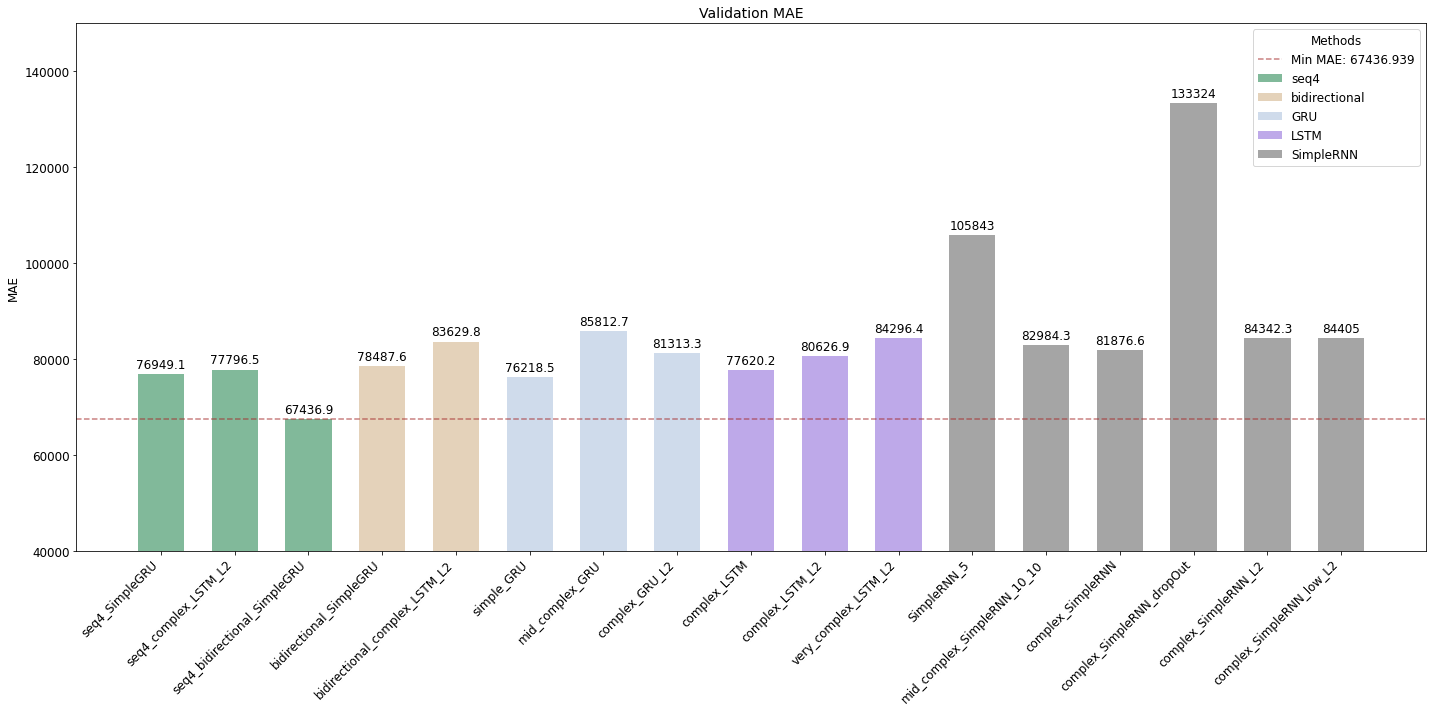

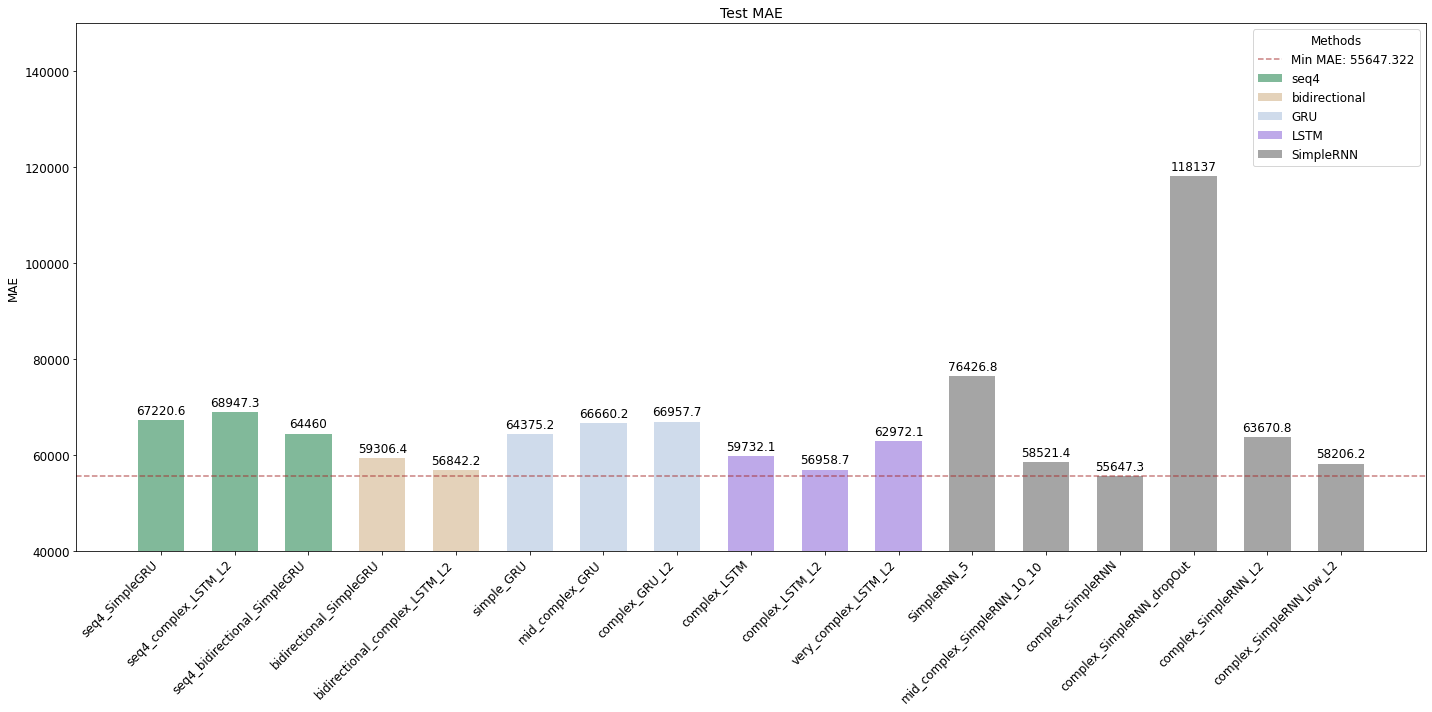

In [115]:
plot_results_grouped(val_results_by_model, title='Validation MAE', y_lim=(40000, 150000))
plot_results_grouped(test_results_by_model, title='Test MAE', y_lim=(40000, 150000))


<div style="background-color: #e6ffe6; padding: 10px;">

## Summary of Experimental Insights

Throughout our extensive experimentation with various RNN architectures, including Simple RNNs, LSTMs, and GRUs, we've embarked on a comprehensive journey to fine-tune our model's performance for a particular task. Our experiments have spanned from basic models to increasingly complex iterations, incorporating techniques such as dropout, L1, L2 regularization, and innovative configurations like bidirectional layers. In our exploration of loss functions, we tested several, including RMS, but found that MAE (Mean Absolute Error) yielded the best results, aligning closely with our chosen metric for performance evaluation. This could be attributed to MAE's straightforward nature, which directly mirrors the average magnitude of errors in predictions without giving undue weight to outliers, making it inherently aligned with our evaluation metric and perhaps offering a more intuitive grasp of model performance.

One notable observation across the board was the models' pronounced sensitivity to regularization, which often led to a significant deterioration in performance when conventional approaches were applied. Interestingly, the application of very light L2 regularization emerged as a slightly more effective strategy, notably enhancing model stability without severely compromising the learning capabilities.

A critical insight from our experiments is the delicate balance between model complexity and performance. Initially, augmenting the model's complexity seemed promising, as evidenced by improved metrics in medium-complexity RNNs. However, further increasing complexity, especially with very complex LSTM configurations, did not yield the anticipated benefits. This plateau suggests that there's an optimal level of complexity beyond which additional layers or neurons cease to contribute to performance improvement and may even degrade it.

Moreover, the exploration of bidirectional layers, particularly with GRU and LSTM models, provided mixed outcomes. While offering a nuanced understanding of sequential data by analyzing it from both directions, these configurations didn't consistently outperform their unidirectional counterparts, underlining the importance of contextual appropriateness of architectural choices.

The experimental journey also highlighted the potential of extending sequence sizes, which, in some cases, led to better model performance by providing a richer contextual backdrop for predictions. This suggests that for certain tasks, the amount of contextual information can be as crucial as the model architecture itself.

### Important Insights

- **Sensitivity to Regularization:** A consistent theme across our models was their sensitivity to regularization, particularly Dropout and L2. This often exacerbated performance issues rather than mitigating overfitting as expected. Light L2 regularization offered a middle ground, improving stability without the adverse effects seen with heavier regularization.
  
- **Optimal Model Complexity:** Our findings underscore the existence of an optimal complexity threshold. Medium complexity models tended to perform better, suggesting a diminishing return or even negative impact of further complexity increases.
  
- **Bidirectional Layers and Sequence Length:** The incorporation of bidirectional layers and adjustment of sequence lengths were met with varying success. These results underscore the necessity of tailoring model architecture to the specific characteristics of the task at hand, as well as the data's nature.

- **Early Stopping as a Regularization Strategy:** Among the regularization techniques explored, Early Stopping emerged as a particularly effective method for preventing overfitting, highlighting its utility in training models more attuned to the nuances of the given data without overcomplicating the regularization approach.

- **Choice of Loss Function:** The selection of MAE as the loss function, which also aligns with our evaluation metric, has proven to be particularly effective. This congruence between the loss and evaluation metrics may simplify the optimization process, providing a direct correlation between training objectives and evaluation goals, thus facilitating a more straightforward assessment of model performance.

These insights collectively inform a nuanced approach to model development, emphasizing the careful consideration of architecture, regularization, the specific dynamics of the task and data at hand, and the strategic selection of loss functions.


</div>